In [1]:
# set globals

# do Google Colab things
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    IN_COLAB = True
except:
    IN_COLAB = False

# install dependencies
path_to_coderepo = (
    "/content/drive/MyDrive/ML_project/code_repo/flare-finder" if IN_COLAB else "."
)
if IN_COLAB:
    !pip install -r {path_to_coderepo}/requirements.txt

# import standard libraries
import matplotlib.pyplot as plt
import pandas as pd
import sys

# import custom libraries
if f'{path_to_coderepo}/src' not in sys.path:
    sys.path.append(f'{path_to_coderepo}/src')
from big_flare_finder import BigFlareFinder

ModuleNotFoundError: No module named 'torch'

In [4]:
# creating model class for big flare prediction


from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet18_Weights
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pdb

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


class BigFlareFinder:
    def __init__(self):

        # init pytorch model
        self.pytorch_model = None

        # set things to make training deterministic
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.manual_seed(42)
        torch.use_deterministic_algorithms(True)

        # set device
        self.device = None
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    def fit(self, image_paths, image_labels, val_frac=0.5):

        # split the data into train and validation using time
        image_paths_train, image_paths_val, image_labels_train, image_labels_val = (
            BigFlareFinder.split_into_train_test_by_time(image_paths, image_labels, val_frac)
        )

        # for training, augment minority-class by making copies
        image_paths_train, image_labels_train = BigFlareFinder.augment_minority_class(
            image_paths_train, image_labels_train
        )

        # get dataloader for train and validation data
        train_loader = BigFlareFinder.preprocess(image_paths_train, image_labels_train)
        validation_loader = BigFlareFinder.preprocess(image_paths_val, image_labels_val)

        # fit pytorch model using dataloader

        # load resnet18 model
        # model_resnet18 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
        model_resnet18 = torch.hub.load(
            "pytorch/vision", "resnet18", weights=ResNet18_Weights.DEFAULT
        )

        # Freeze all params except the BatchNorm layers, as here they are trained to the
        # mean and standard deviation of ImageNet and we may lose some signal
        for name, param in model_resnet18.named_parameters():
            if "bn" not in name:
                param.requires_grad = False

        # reduce number of output classes in model
        num_classes = 2
        model_resnet18.fc = nn.Sequential(
            nn.Linear(model_resnet18.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

        model_resnet18.to(self.device)
        optimizer = optim.Adam(model_resnet18.parameters())
        loss_fn = torch.nn.CrossEntropyLoss()
        epochs = 7  # 10
        target_class = 1

        for epoch in range(epochs):
            training_loss = 0.0
            valid_loss = 0.0
            model_resnet18.train()
            for batch in train_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                targets = targets.type(torch.LongTensor)
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                output = model_resnet18(inputs)
                loss = loss_fn(output, targets)

                loss.backward()
                optimizer.step()
                training_loss += loss.data.item() * inputs.size(0)
            training_loss /= len(train_loader.dataset)

            model_resnet18.eval()
            # all_targets = []
            image_labels_val_pred = []

            for batch in validation_loader:
                inputs, targets = batch
                inputs = inputs.to(self.device)
                output = model_resnet18(inputs)
                predictions = torch.max(F.softmax(output, dim=1), dim=1)[1]
                image_labels_val_pred.extend(predictions.cpu().numpy())

            print(
                f"Train epoch: {epoch}"
                f", train_loss: {round(training_loss, 2)}"
                f"\nval_metrics: {BigFlareFinder.get_model_performance_metrics(image_labels_val, image_labels_val_pred)}"
            )

        # train on the val data (which was excluded from training earlier)
        image_paths_val, image_labels_val = BigFlareFinder.augment_minority_class(
            image_paths_val, image_labels_val
        )
        val_loader = BigFlareFinder.preprocess(image_paths_val, image_labels_val)
        for epoch in range(epochs):
            for batch in val_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                targets = targets.type(torch.LongTensor)
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                output = model_resnet18(inputs)
                loss = loss_fn(output, targets)
                loss.backward()
                optimizer.step()
                training_loss += loss.data.item() * inputs.size(0)
            training_loss /= len(train_loader.dataset)
            model_resnet18.eval()
            print(
                f"Train-on-val epoch: {epoch}"
                f", train_loss: {round(training_loss, 2)}"
            )

        # save trained model to self
        self.pytorch_model = model_resnet18

    @staticmethod
    def augment_minority_class(image_paths, image_labels):
        # TODO: remove funtion after implementing augmentation in preprocess

        # init resut
        image_paths_aug = []
        image_labels_aug = []

        # augment data
        image_labels_counts = pd.Series(image_labels).value_counts().sort_values()
        minority_class, majority_class = tuple(image_labels_counts.index)
        class_count_diff = (
            image_labels_counts[majority_class] - image_labels_counts[minority_class]
        )
        image_paths_new = (
            pd.Series(image_paths[image_labels == minority_class])
            .sample(class_count_diff, replace=True, random_state=42)
            .to_list()
        )
        image_labels_new = [minority_class] * class_count_diff
        image_paths_aug = image_paths + image_paths_new
        image_labels_aug = image_labels + image_labels_new

        # shuffle augmented data
        image_paths_aug, image_labels_aug = zip(
            *np.random.default_rng(seed=42).permutation(
                list(zip(image_paths_aug, image_labels_aug))
            )
        )
        image_paths_aug = [str(path) for path in image_paths_aug]
        image_labels_aug = [float(label) for label in image_labels_aug]

        return image_paths_aug, image_labels_aug

    def predict(self, image_paths):

        # init result
        pred_labels = []

        # get dataloader
        dataloader = BigFlareFinder.preprocess(image_paths)

        # make predictions
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(self.device)
            output = self.pytorch_model(inputs)
            predictions = torch.max(F.softmax(output, dim=1), dim=1)[1]
            pred_labels.extend(predictions.cpu().numpy())

        return pred_labels

    def pred_proba(self, image_paths):

        # init result
        pred_probas = []

        # get dataloader
        dataloader = BigFlareFinder.preprocess(image_paths)

        # make predictions
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(self.device)
            output = self.pytorch_model(inputs)
            predictions = F.softmax(output, dim=1)[:, 1]

            # pdb.set_trace()

            pred_probas.extend(predictions.detach().cpu().numpy().tolist())

        return pred_probas

    @staticmethod
    def get_model_performance_metrics(y_true, y_pred):
        metrics_dict = {
            "accuracy": round(accuracy_score(y_true, y_pred), 2),
            "f1": round(f1_score(y_true, y_pred), 2),
            "precision_class_1": round(
                precision_score(y_true, y_pred, zero_division=0), 2
            ),
            "recall_class_1": round(recall_score(y_true, y_pred, zero_division=0), 2),
            "actual_distru": pd.Series(y_true).value_counts().sort_index().to_dict(),
            "pred_distru": pd.Series(y_pred).value_counts().sort_index().to_dict(),
        }
        return metrics_dict

    @staticmethod
    def preprocess(image_paths, image_labels=None, augment_minority_class=False):
        # TODO: add data augmentation option; see https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch

        # make dataset of image_paths and image_labels
        image_dimension = 224
        image_transforms = transforms.Compose(
            [
                transforms.Resize((image_dimension, image_dimension)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        image_labels = image_labels or [0] * len(image_paths)
        dataset = CustomImageDataset(image_paths, image_labels, image_transforms)

        # make dataloader for dataset
        batch_size = 32
        num_workers = 2
        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
        )

        return dataloader

    @staticmethod
    def split_into_train_test_by_time(image_paths, image_labels, test_frac):
        # make images_df
        images_df = pd.DataFrame(
            {"image_path": image_paths, "image_label": image_labels}
        )

        # add a datetime column
        images_df["datetime"] = pd.to_datetime(
            images_df["image_path"].str.split("/").str[-1].str[None:-4]
        )

        # sort images_df by datetime
        images_df = images_df.sort_values("datetime")

        # find min and max datetimes of images_df
        min_datetime = images_df["datetime"].min()
        max_datetime = images_df["datetime"].max()

        # find time span between min and max datetimes (in days)
        time_span_in_days = (max_datetime - min_datetime).days

        # get the two dfs by splitting the time span into the desired ratio
        num_train_days = time_span_in_days * (1 - test_frac)
        end_train_datetime = min_datetime + pd.to_timedelta(num_train_days, unit="days")
        train_df = images_df[images_df["datetime"] <= end_train_datetime]
        test_df = images_df[images_df["datetime"] > end_train_datetime]

        # get image_paths_train, image_paths_test, image_labels_train, image_labels_test
        image_paths_train = train_df["image_path"].to_list()
        image_paths_test = test_df["image_path"].to_list()
        image_labels_train = train_df["image_label"].to_list()
        image_labels_test = test_df["image_label"].to_list()

        return (
            image_paths_train,
            image_paths_test,
            image_labels_train,
            image_labels_test,
        )


In [5]:
# we want to test the pred_proba functionality
# * we want to train the model and use it get prediction probabilites given an image as input

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna()

# [TEMP] shorten big_flare_labels_df
big_flare_labels_df = big_flare_labels_df.sort_values('solar_image_filename').iloc[None:500]

image_paths = (
    image_folder_path + "/" + big_flare_labels_df["solar_image_filename"]
).to_list()
image_labels = big_flare_labels_df["is_big_flare"].to_list()

# split image_paths and image_labels by time:
#     image_paths_train, image_paths_test, image_labels_train, image_labels_test
test_frac = 0.5
image_paths_train, image_paths_test, image_labels_train, image_labels_test = (
    BigFlareFinder.split_into_train_test_by_time(image_paths, image_labels, test_frac)
)

# train model
big_flare_finder = BigFlareFinder()
model = big_flare_finder.fit(image_paths_train, image_labels_train)

# get prediction probabilites
image_pred_probas_test = big_flare_finder.pred_proba(image_paths_test)
print(f"\nimage_pred_probas_test: {image_pred_probas_test}")

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 253MB/s]


Train epoch: 0, train_loss: 0.28
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 1, train_loss: 0.08
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 2, train_loss: 0.05
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 3, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 4, train_loss: 0.04
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 5, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 

In [6]:
# compare pred_proba labels to pred labels
# * we start with the fitted model big_flare_finder, and the test image_paths
# * get the pred_proba labels and the predict labels

pred_probas = big_flare_finder.pred_proba(image_paths_test)
pred_probas_labels = [1 if pred_proba > 0.5 else 0 for pred_proba in pred_probas]
predict_labels = big_flare_finder.predict(image_paths_test)

# check if pred_probas_labels is equal to predict_labels
if pred_probas_labels == predict_labels:
    print("pred_probas_labels is equal to predict_labels")
else:
    print("pred_probas_labels is not equal to predict_labels")


pred_probas_labels is equal to predict_labels


In [1]:
image_paths_test

NameError: name 'image_paths_test' is not defined

In [6]:
# get predict() performance of model on test data

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna()

# [TEMP] shorten big_flare_labels_df
big_flare_labels_df = big_flare_labels_df.sort_values('solar_image_filename').iloc[None:500]

image_paths = (
    image_folder_path + "/" + big_flare_labels_df["solar_image_filename"]
).to_list()
image_labels = big_flare_labels_df["is_big_flare"].to_list()

# split image_paths and image_labels by time:
#     image_paths_train, image_paths_test, image_labels_train, image_labels_test
test_frac = 0.5
image_paths_train, image_paths_test, image_labels_train, image_labels_test = (
    BigFlareFinder.split_into_train_test_by_time(image_paths, image_labels, test_frac)
)

# train model
big_flare_finder = BigFlareFinder()
model = big_flare_finder.fit(image_paths_train, image_labels_train)

# make predictions
image_labels_test_pred = big_flare_finder.predict(image_paths_test)

# get pred metrics
test_metrics = BigFlareFinder.get_model_performance_metrics(image_labels_test, image_labels_test_pred)
print(f"\ntest_metrics: {test_metrics}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train epoch: 0, train_loss: 0.28
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 1, train_loss: 0.08
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 2, train_loss: 0.05
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 3, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 4, train_loss: 0.04
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 5, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 

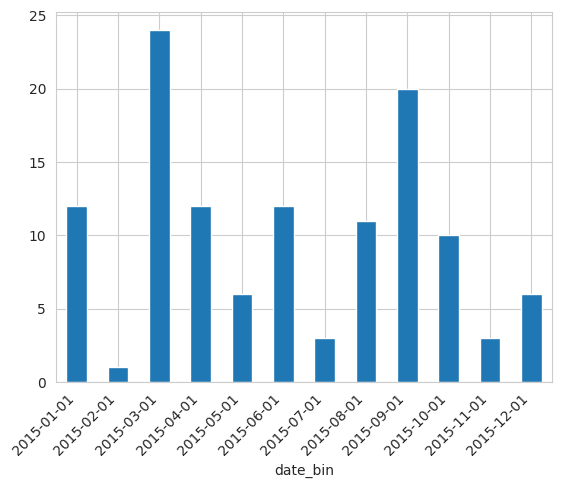

In [ ]:
# plot histogram of big flares as a function of month

# set the style of plotting to seaborn whitegrid
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna().sort_values('solar_image_filename')

# get datetime from solar_image_filename in big_flare_labels_df
big_flare_labels_df['datetime'] = pd.to_datetime(big_flare_labels_df['solar_image_filename'].str.split('.').str[0], errors = 'coerce')

# bin datetime to first day of month
big_flare_labels_df['date_bin'] = big_flare_labels_df['datetime'].dt.to_period('M').dt.to_timestamp()

# groupby date_bin and sum is_big_flare
# rotate the x axis labels
ax = big_flare_labels_df.groupby('date_bin')['is_big_flare'].sum().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
_ = ax.set_xticklabels([label.get_text()[:10] for label in ax.get_xticklabels()])

In [ ]:
# modify pred to output probabilities and rename it is predict_proba
# test on the small dataset

In [ ]:
# train big-flare classifier
# * train big-flare classifier on first 70% of 2015 and test on last 30%
# * show prediction-quality (accuracy, f1, precn, recall)



In [ ]:
# show the timeline of flares in test along with predictions

In [ ]:
# show what the model learned
# * some viz of features picked up by the model for big-flares